In [1]:
import pillow_jpls, torch, io, datasets, PIL.Image,  numpy as np
from throughput.image import wallclock
from huggingface_hub import hf_hub_download
from types import SimpleNamespace
from livecodec.codec import AutoCodecND, latent_to_pil, pil_to_latent, compand
from torchvision.transforms.v2.functional import to_pil_image, pil_to_tensor, resize

dataset = datasets.load_dataset("danjacobellis/kodak")
checkpoint_file = hf_hub_download(
    repo_id="danjacobellis/liveaction",
    filename="lsdir_f16c48_lambdap1.pth"
)
checkpoint = torch.load(checkpoint_file, map_location="cpu",weights_only=False)
config = checkpoint['config']
codec = AutoCodecND(
    dim=2,
    input_channels=config.input_channels,
    J = int(np.log2(config.F)),
    latent_dim=config.latent_dim,
    encoder_depth = config.encoder_depth,
    encoder_kernel_size = config.encoder_kernel_size,
    decoder_depth = config.decoder_depth,
    lightweight_encode = config.lightweight_encode,
    lightweight_decode = config.lightweight_decode,
)
codec.load_state_dict(checkpoint['state_dict'])
codec.eval();
dtype = torch.float

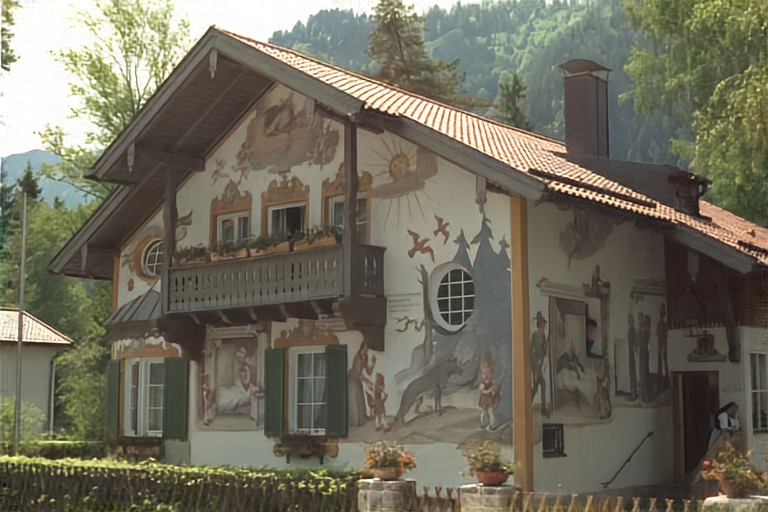

analysis: median=32.79ms, mean=48.38ms, throughput=11.99 MP/s
transfer: median=0.62ms, mean=0.63ms, throughput=639.22 MP/s
store: median=5.78ms, mean=5.73ms, throughput=68.06 MP/s
encode: median=39.52ms, mean=54.80ms, throughput=9.95 MP/s
decode: median=74.22ms, mean=99.35ms, throughput=5.30 MP/s


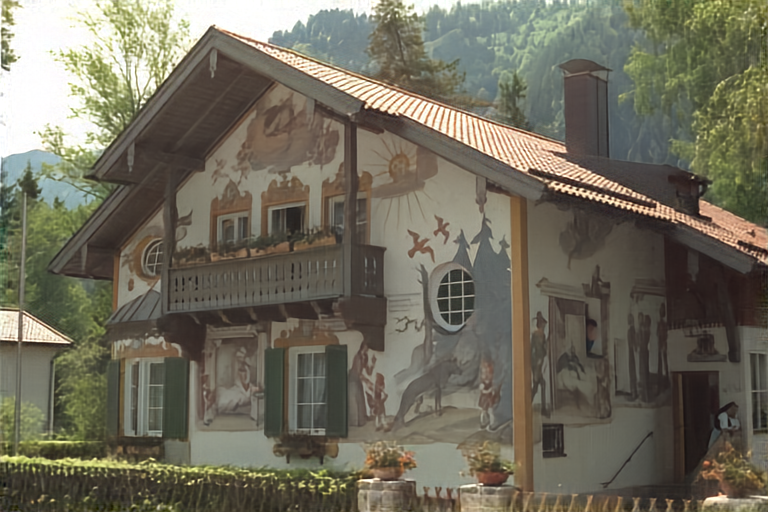

analysis: median=105.64ms, mean=106.30ms, throughput=3.72 MP/s
transfer: median=0.01ms, mean=0.01ms, throughput=37628.25 MP/s
store: median=4.69ms, mean=4.59ms, throughput=83.75 MP/s
encode: median=110.79ms, mean=110.95ms, throughput=3.55 MP/s
decode: median=2021.27ms, mean=2000.39ms, throughput=0.19 MP/s


In [2]:
for device in ['xpu','cpu']:
    wallclock.reset()
    codec.to(device)


    for _ in range(5):
        for sample in dataset['validation']:
            
            img = sample['image']
            x = pil_to_tensor(img).unsqueeze(0).to(dtype) / 127.5 - 1.0
            x = x.to(device)

            with wallclock('encode'):
                with wallclock('analysis'):
                    with torch.inference_mode():
                        x = codec.wpt(x)
                        x = 12.8 * compand(x, power=0.4)
                        x = x.to(device)
                        x = codec.encoder_blocks(x)
                        x = codec.conv_down(x)
                        x = codec.quantize.compand(x).round()
                        
                with wallclock('transfer'):
                    x = x.cpu()
                    
                with wallclock('store'):
                    x = latent_to_pil(x, n_bits=8, C=3)[0]
                    buff = io.BytesIO()
                    x.save(buff, format='JPEG-LS', near_lossless=0)
                
            with wallclock('decode'):
                x = pil_to_latent([PIL.Image.open(buff)], N=config.latent_dim, n_bits=8, C=3).to(device).to(dtype)        
                x = x.to(device)
                with torch.inference_mode():
                    x = codec.decode(x).clamp(-1,1)
            
    display(to_pil_image(x[0]/2+0.5))
    wallclock.summary(pixels=512*768)